In [1]:
from rdbms.rdbms import RDBMS
from data_structure.query import Query
from components.stanford_parser import StanfordParser
from components.node_mapper import NodeMapper
from components.entity_resolution import entity_resolute
from components.tree_structure_adjustor import TreeStructureAdjustor
from components.explainer import explain
from components.sql_translator import translate

from config import ConfigHandler

In [2]:
config_json_text = '''{
    "connection":{
        "host": "localhost",
        "password":"paulo",
        "user":"paulo",
        "database":"mas"
    },
    "defaultImplementation": true,
    "loggingMode": "ERROR",
    "zfiles_path":"/home/pr3martins/Desktop/zfiles",
}
'''
config = ConfigHandler(reset=True,config_json_text=config_json_text)

In [3]:
rdbms = RDBMS(config)

In [4]:
query_line='return me the authors who have papers in VLDB conference before 2002 after 1995.'
query = Query(query_line,rdbms.schema_graph)

## Stanford Dependency Parser

In [5]:
StanfordParser(query)
query.parse_tree

(1)ROOT
    (2)return
        (3)me
        (4)authors
            (5)the
            (6)have
                (7)who
                (8)papers
                    (9)conference
                        (10)in
                        (11)VLDB
                        (12)2002
                            (13)before
                (14)1995
                    (15)after

**Important Note**: The graph vizualitation requires the program [Graphviz](https://graphviz.org/) (alongside with the graphviz python package) to be installed.

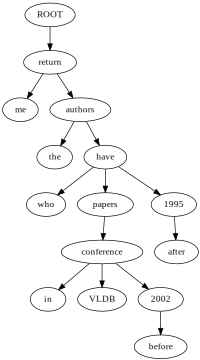

In [6]:
query.parse_tree.show()

## Node Mapper

In [7]:
NodeMapper.phrase_process(query,rdbms,config)

,Keyword,Table,Column,TAG
0,authors,author,name,NT
1,papers,publication,title,VT
2,conference,conference,name,NT
3,vldb,conference,name,VT
4,2002,publication,year,NT
5,1995,publication,year,NT


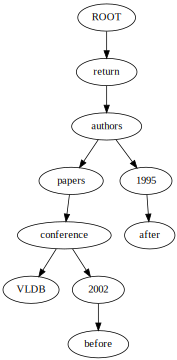

In [8]:
query.parse_tree.show()

##  Entity Resolution

The entity pairs denote that two nodes represente the same entity.

In [9]:
entity_resolute(query)
query.entities

[EntityPair('(11)VLDB', '(9)conference')]

## Tree Structure Adjustor

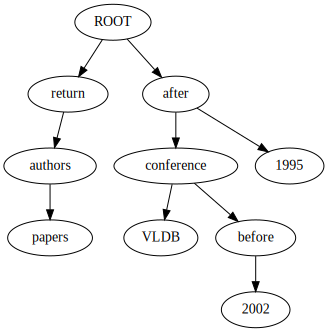

In [10]:
TreeStructureAdjustor.tree_structure_adjust(query,rdbms)
query.query_tree.show()

## Explainer

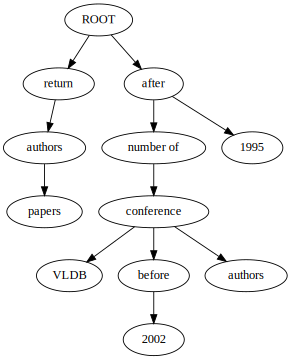

In [11]:
explain(query)
query.query_tree.show()

## SQL Translator

**Important Node**: The error message is resultant of line 191 of file data_structure/block.py

In [12]:
translate(query, rdbms)
print(query.translated_sql)

ERROR:/home/pr3martins/nalir-sbbd/data_structure/block.py:Error by choice none


SELECT DISTINCT author.name, block_1.count
FROM publication, author, writes, (SELECT count(conference.name) as count, author.name FROM conference, author, publication, writes WHERE conference.name = "VLDB" AND publication.year < 2002 AND conference.cid = publication.cid AND publication.pid = writes.pid AND writes.aid = author.aid AND conference.cid = publication.cid) block_1
WHERE block_1.count > 1995 AND publication.title = "Papers" AND author.name = block_1.name AND author.aid = writes.aid AND writes.pid = publication.pid
